#### Notes:

- datasets unfiltered and filtered

- third attempt: improved data collection (electrode placement, skin preparation, ...)
- best accuracys:
    - DATA2 FILTERED Feature combination: MAV, WL, VAR: the average accuracy using cross validation with 10 folds across selected features is 0.8760233918128655
    - DATA2 UNFILTERED the average accuracy using cross validation with 10 folds across selected features is 0.8719298245614034
        Feature combination: RMS, MAV, WL
    - DATA4 keyboard up Feature combination: RMS, MAV, WL: the average accuracy using cross validation with 10 folds across selected features is 0.9452205882352942

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from typing import Dict, List, Tuple, Optional
from scipy import stats
import time
from random import randrange
import statistics

## functions

### import data

In [3]:
def read_from_file(file: str) -> pd.DataFrame:
    """
    Opens a csv file as pandas dataframe.
    Cleans the data by removing all irrelevant data. (direction == 0)
    Returns dataframe.
    
    Args:
        file (str): The path to the file to open. 
        
    Returns:
        df.dataframe: df including all data for direction 1 and 2
    """
    
    data = pd.read_csv(file)
    
    # data_up = data.loc[data["direction"]== 1]
    # data_down = data.loc[data["direction"]== 2]
    data_clean = data.loc[data["direction"] > 0]
    
    return data_clean
    

### RMS (root mean square)
##### RMS is related to the constant force, and the non-fatiguing contractions of thge muscles

In [4]:
def rms_per_epoch(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Input is a df filled with emg data, epoch_ids and direction.
    Calculates the RootMeanSquare (RMS) per muscle for each epoch.
    
    Args:
        df including all relevant data to calculate
        
    Returns:
        df including RMS per muscle per epoch
    
    '''
    
    # get n_epoch by finding max value
    n_epoch = data['epoch_ixs'].max()
    
    rms_muscle1 = []
    rms_muscle2 = []
    direction = []

    for i in range(1,n_epoch+1):
        cases = data.loc[data["epoch_ixs"] == i]

        # calculate RMS for muscle1 and muscle2
        RMS_m1 = np.sqrt(np.sum(np.square(cases.muscle1))/len(cases))
        rms_muscle1.append(RMS_m1)

        RMS_m2 = np.sqrt(np.sum(np.square(cases.muscle2))/len(cases))
        rms_muscle2.append(RMS_m2)

        direction.append(cases['direction'].values[0])
       
    # create data frame with direction and RMS_m1, RMS_m2
    rms_data = {'direction': direction, 'rms_m1': rms_muscle1, 'rms_m2': rms_muscle2}
    RMS = pd.DataFrame(rms_data)
    
    return RMS
    

### MAV (mean absolute value)
##### MAV is a method of detecting and gauging muscle contraction levels

In [5]:
def mav_per_epoch(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Input is a df filled with emg data, epoch_ids and direction.
    Calculates the MeanAbsoluteValue (MAV) per muscle for each epoch.
    
    Args:
        df including all relevant data to calculate
        
    Returns:
        df including mav per muscle per epoch
    
    '''
    
    # get n_epoch by finding max value
    n_epoch = data['epoch_ixs'].max()
    
    mav_muscle1 = []
    mav_muscle2 = []
    direction = []

    for i in range(1,n_epoch+1):
        cases = data.loc[data["epoch_ixs"] == i]

        # calculate mav for muscle1 and muscle2
        MAV_m1 = np.sum(np.absolute(cases.muscle1))/len(cases)      
        mav_muscle1.append(MAV_m1)

        MAV_m2 = np.sum(np.absolute(cases.muscle2))/len(cases)      
        mav_muscle2.append(MAV_m2)

        direction.append(cases['direction'].values[0])
       
    # create data frame with direction and MAV_m1, MAV_m2
    mav_data = {'direction': direction, 'mav_m1': mav_muscle1, 'mav_m2': mav_muscle2}
    MAV = pd.DataFrame(mav_data)
    
    return MAV
    

### VAR (variance of EMG)
##### expresses the power of the EMG signal as useable feature

In [6]:
def var_per_epoch(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Input is a df filled with emg data, epoch_ids and direction.
    Calculates the variance (VAR) per muscle for each epoch.
    
    Args:
        df including all relevant data to calculate
        
    Returns:
        df including var per muscle per epoch
    
    '''
    
    # get n_epoch by finding max value
    n_epoch = data['epoch_ixs'].max()
    
    var_muscle1 = []
    var_muscle2 = []
    direction = []

    for i in range(1,n_epoch+1):
        cases = data.loc[data["epoch_ixs"] == i]
        
        if len(cases)==1:
            print("WARNING: epoch", i, "is too short; it only contains 1 element.")
            
        else:

        # calculate VAR for muscle1 and muscle2
            VAR_m1 = np.sum(np.square(cases.muscle1))/(len(cases)-1) 
            var_muscle1.append(VAR_m1)

            VAR_m2 = np.sum(np.square(cases.muscle2))/(len(cases)-1)      
            var_muscle2.append(VAR_m2)

            direction.append(cases['direction'].values[0])
       
    # create data frame with direction and VAR_m1, VAR_m2
    var_data = {'direction': direction, 'var_m1': var_muscle1, 'var_m2': var_muscle2}
    VAR = pd.DataFrame(var_data)
    
    return VAR

### WL (Waveform Length)
##### the WL is intuitively the cummulative length of the waveform over the segment. the resultant values of the WL calculation indicate a measure of the waveform amplitude, frequency, and duration.

In [7]:
def wl_per_epoch(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Input is a df filled with emg data, epoch_ids and direction.
    First finds the shortest epoch n_shortest.
    Calculates the waveform length (WL) per muscle for each epoch,
    only considering the first n_shortest entries.
    
    Args:
        df including all relevant data to calculate
        
    Returns:
        df including wl per muscle per epoch
    
    '''
 
    n_epoch = data['epoch_ixs'].max()

    # find closest epoch_length >=  min_length
    n_shortest = 1000
    min_length = 10

    for i in range(1,n_epoch+1):
        epoche_i = data.loc[data["epoch_ixs"] == i]

        if len(epoche_i) >= min_length and len(epoche_i) <= n_shortest: 
            n_shortest = len(epoche_i)

        elif len(epoche_i) <= min_length:
            print('WARNING: epoch', i,'has a length of ',len(epoche_i))


    # calculate WL for first n_shortest entries of each epoch
    wl_muscle1 = []
    wl_muscle2 = []
    direction = []

    for i in range(1,n_epoch+1):
        cases = data.loc[data["epoch_ixs"] == i]

        # convert pd.series to np.array
        arr_m1 = cases.muscle1.to_numpy()
        arr_m2 = cases.muscle2.to_numpy()

        WL_m1 = 0
        WL_m2 = 0

        for j in range (1,n_shortest):

            WL_m1_curr = np.absolute(arr_m1[j]-arr_m1[(j-1)])
            WL_m1 = WL_m1 + WL_m1_curr

            WL_m2_curr = np.absolute(arr_m2[j]-arr_m2[(j-1)])
            WL_m2 = WL_m2 + WL_m2_curr

        wl_muscle1.append(WL_m1)
        wl_muscle2.append(WL_m2)

        direction.append(cases['direction'].values[0])

    wl_data = {'direction': direction, 'wl_m1': wl_muscle1, 'wl_m2': wl_muscle2}
    WL = pd.DataFrame(wl_data)
    
    return WL

In [8]:
def combine_data(dataset: pd.DataFrame, RMS = False, MAV = False, VAR = False, WL = False)-> pd.DataFrame:
    """
    Calculates 1-4 features, z_standarisation of the data and combines them to new df.
    Select features by setting boolean to True.
    
    Args:
        df: including the labelled data (direction 1 + 2) for both muscles. 
        feature: optional boolean arg for selected features.
        
    Returns:
        df: combined and z-standarized data.
    """
    
    if RMS == MAV == VAR == WL == False:
        print('Error. Please select features for combined data.')
    
    else:
        combined_data = None
        
        if RMS == True:
            rms_data = rms_per_epoch(dataset)
            combined_data = rms_data
                    
        if MAV == True:
            mav_data = mav_per_epoch(dataset)
            
            if combined_data is not None:
                combined_data = pd.concat([combined_data,mav_data], axis=1)
            
            else:
                combined_data = mav_data
            
        if VAR == True:
            var_data = var_per_epoch(dataset)
            
            if combined_data is not None:
                combined_data = pd.concat([combined_data,var_data], axis=1)
            
            else:
                combined_data = var_data
                
        if WL == True: 
            wl_data = wl_per_epoch(dataset)
            
            if combined_data is not None:
                combined_data = pd.concat([combined_data,wl_data], axis=1)
                
            else:
                combined_data = wl_data
        
        # remove all unneccesary direction columns
        combined_data = combined_data.loc[:,~combined_data.columns.duplicated()]
        
        # z-standarization of all emg data besides direction-labels
        ### HERE: z-stamdarization along datapoints per feature
        # combined_data.iloc[:,1:] = stats.zscore(combined_data.iloc[:,1:], axis=0)

        return combined_data    

**@Nils**: No need to z-score here or with the real-time data, it does not make any difference to the results. However, when plotting the description of the features as a box plot for example, you can zscore to plot them on the same axis.

In [9]:
def feature_pooling(data: pd.DataFrame):
    """
    Uses function combine_data to generate combined data sets.
    Pools features and calculates LDA accuracy for different feature pools.
    Prints feature combination and score.
    
    ### option for smarter code: instead of always generating 
    
    Args:
        df: including the data set.
    """
    # subsets [0, RMS, RMS, MAV, MAV, WL, WL, VAR, VAR]
    
    # RMS = True, MAV = True, WL = True, VAR = True
    df_all_features = combine_data(data, RMS = True, MAV = True, WL = True, VAR = True)
    print('Feature combination: RMS, MAV, WL, VAR')  
    LDA_classifier(df_all_features)
    
    ### instead of df_selected_n possible to use LDA_classifier with specifying subsets
    # RMS = FALSE, MAV = True, WL = True, VAR = True 
    #LDA_classifier(df_all_features, subsets = list(range(3,9)))
    # RMS = True, MAV = FALSE, WL = True, VAR = True
    #LDA_classifier(df_all_features, subsets = [1,2,5,6,7,8])
    # RMS = True, MAV = True, WL = FALSE, VAR = True
    #LDA_classifier(df_all_features, subsets = [1,2,3,4,7,8])
    # RMS = True, MAV = True, WL = True, VAR = FALSE
    #LDA_classifier(df_all_features, subsets = [1,2,3,4,5,6])
    # MAV = True, VAR = True
    #LDA_classifier(df_all_features, subsets = [3,4,7,8])
    
    
    # RMS = FALSE, MAV = True, WL = True, VAR = True
    df_selected_1 = combine_data(data, RMS = False, MAV = True, WL = True, VAR = True)
    print('Feature combination: MAV, WL, VAR') 
    LDA_classifier(df_selected_1)
    
    # RMS = True, MAV = FALSE, WL = True, VAR = True
    df_selected_2 = combine_data(data, RMS = True, MAV = False, WL = True, VAR = True)
    print('Feature combination: RMS, WL, VAR') 
    LDA_classifier(df_selected_2)
    
    # RMS = True, MAV = True, WL = FALSE, VAR = True
    df_selected_3 = combine_data(data, RMS = True, MAV = True, WL = False, VAR = True)
    print('Feature combination: RMS, MAV, VAR')
    LDA_classifier(df_selected_3)
    
    # RMS = True, MAV = True, WL = True, VAR = FALSE
    df_selected_4 = combine_data(data, RMS = True, MAV = True, WL = True, VAR = False)
    print('Feature combination: RMS, MAV, WL')
    LDA_classifier(df_selected_4)
    
    # MAV = True, VAR = True
    print('Feature combination: MAV, VAR')
    df_selected_5 = combine_data(data, RMS = False, MAV = True, WL = False, VAR = True)
    LDA_classifier(df_selected_5)
    

### LDA with CV

In [22]:
def LDA_classifier(data: pd.DataFrame, folds = 10, subsets = [], timer = False):
    """
    Trains and tests LDA classifier and calculates the accuracy.
    Prints the average accuracy and stadard deviation.
    
    Args:
        df: including the labelled data (direction 1 + 2) for both muscles. 
        
        folds: number of folds; optional argument for cross validation; default value is 10
        
        subsets (optional): list including the columns of df to do LDA CV on
        
        timer = True: optional parameter to measure time of CV
        
    Returns:
        None  
    """
    if timer == True:
        startTime = time.time()

    # clf = LDA(solver='lsqr',shrinkage='auto')
    clf = LDA()
    
    # splits data randomly in n=folds 
    kfolds = KFold(n_splits=folds, random_state=1, shuffle=True) 
    
    if len(subsets) == 0:
        subsets = list(range(1,len(data.columns)))
    
    cv_results = cross_val_score(clf, data.iloc[:,subsets].values, data.direction, cv=kfolds)
    cv_average = cv_results.mean()
    st_deviation = cv_results.std()
    
    #print(cv_results)
    
    print("%0.3f accuracy with a standard deviation of %0.3f" % (cv_average, st_deviation))

    #print(f'the average accuracy using cross validation with {folds} folds across selected features is {cv_average}')
    
    if timer == True:
        cvTime = (time.time() - startTime)
        print('Cross Validation time in seconds: ' + str(cvTime))
        

**@Nils** We can try the shrinkage auto setting later for real-time application and see if it performs better on unseen data than the presumably overfit model.

### Plotting function

In [11]:
def plot_and_save(data: pd.DataFrame, feature: str, name: str, save: bool = False):
    '''
    Input is a df filled with data to plot and save.
    Plots the data and optionally saves it in current working direction.
    
    Args:
        data: df including all relevant data
        feature: str including the feature name
        name: str including the name of the data set
        save = True to save plot to current working direction.
    '''
    
    x_vals = data.iloc[:,1].name
    y_vals = data.iloc[:,2].name
    
    # plot
    g = sns.lmplot(x=x_vals,y=y_vals, data=data, hue='direction', fit_reg=False)
    g.set_axis_labels('{} muscle1'.format(feature), '{} muscle2'.format(feature))
    plt.title('{} - {}'.format(name, feature))
    if save == True:
        plt.savefig('./plots/{}_{}.pdf'.format(name, feature),dpi=300, bbox_inches='tight')
    
    # warning when saving as .eps   

### DATA EXPLORING

In [41]:
data = read_from_file(file='C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/7/1803_test_2_rotation_fix.csv')

#data = read_from_file(file='C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
#00_Masterarbeit/55_github/proxEMG/data/7/1803_test_2_gesture.csv')

In [34]:
feature_pooling(data)

Feature combination: RMS, MAV, WL, VAR
1.000 accuracy with a standard deviation of 0.000
Feature combination: MAV, WL, VAR
1.000 accuracy with a standard deviation of 0.000
Feature combination: RMS, WL, VAR
0.975 accuracy with a standard deviation of 0.075
Feature combination: RMS, MAV, VAR
0.925 accuracy with a standard deviation of 0.115
Feature combination: RMS, MAV, WL
0.975 accuracy with a standard deviation of 0.075
Feature combination: MAV, VAR
0.950 accuracy with a standard deviation of 0.100


In [35]:
# feature extraction
data_rms = rms_per_epoch(data)
data_mav = mav_per_epoch(data)
data_var = var_per_epoch(data)
data_wl = wl_per_epoch(data)


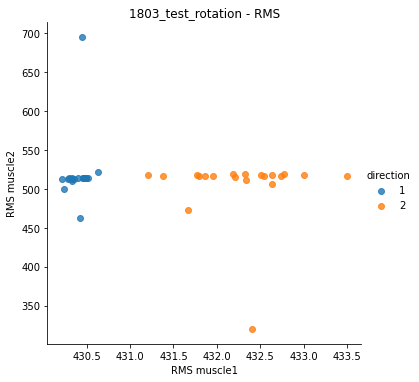

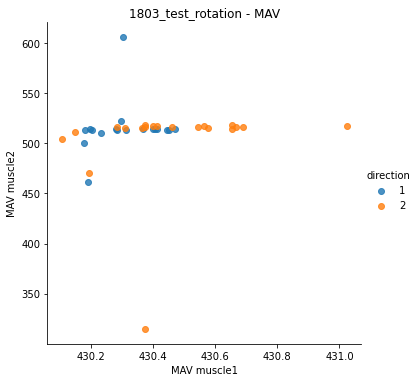

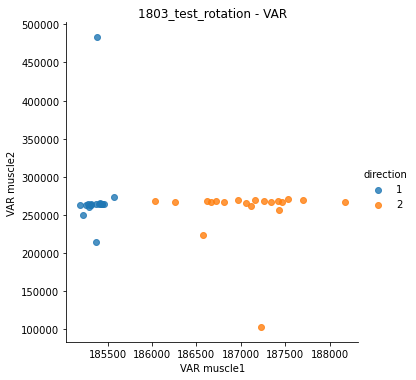

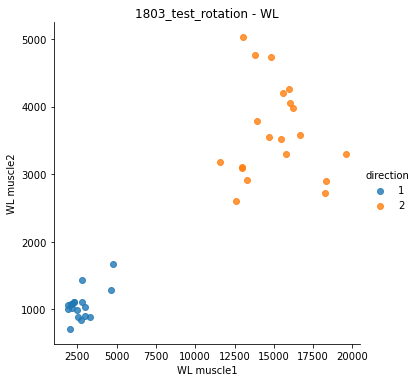

In [36]:
# plot data points m1 + m2 per feature
plot_and_save(data_rms, feature='RMS', name='1803_test_rotation', save=False)
plot_and_save(data_mav, feature='MAV', name='1803_test_rotation', save=False)
plot_and_save(data_var, feature='VAR', name='1803_test_rotation', save=False)
plot_and_save(data_wl, feature='WL', name='1803_test_rotation', save=False)

In [37]:
# plotting dim reduction 
all_data = combine_data(data, RMS = True, MAV = True, WL = False, VAR = True)

# generate "fake" third class to allow n_components=2
all_data.loc[0]=[0,0,0,0,0,0,0]

clf = LDA(n_components=2)

transf_lda = clf.fit_transform(all_data.iloc[:,list(range(1,7))].values, all_data.direction)

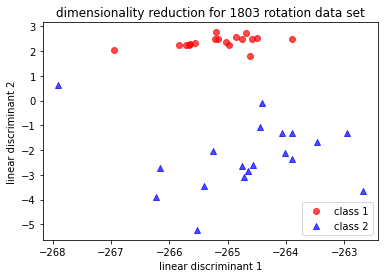

In [49]:
for label,marker,color in zip(range(1,3),('o','^'),('red','blue')):
    plt.scatter(x=transf_lda[:,0][all_data.direction == label],
           y=transf_lda[:,1][all_data.direction == label], marker=marker,
           color=color, alpha=0.7, label='class {}'.format(label))

plt.xlabel('linear discriminant 1')
plt.ylabel('linear discriminant 2')

plt.legend(loc='lower right')
plt.title('dimensionality reduction for 1803 rotation data set')

plt.show()

In [50]:
### variance explained by each coefficient 
# NOTE: vertauscht im Vgl. zu plot?
clf.explained_variance_ratio_

array([9.99997992e-01, 2.00841711e-06])

## code

#### direction 1 and odd epoch_ixs --> clockwise; direction 2 and even epoch_ixs --> anticlockwise

#### data_2: muscles 8-28 and 8-50; reference: wrist

In [ ]:
# unfiltered
data_2 = read_from_file(file='C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/4/data_2.csv')

#data_2 = read_from_file(file='/Users/lukasgehrke/Documents/publications/proxEMG/data/4/data_2.csv')

# feature pooling
feature_pooling(data_2)

In [ ]:
# plotting dim reduction 
all_data = combine_data(data_2, RMS = True, MAV = True, WL = True, VAR = True)

# generate "fake" third class to allow n_components=2
all_data.loc[0]=[0,0,0,0,0,0,0,0,0]

clf = LDA(n_components=2)

transf_lda = clf.fit_transform(all_data.iloc[:,list(range(1,9))].values, all_data.direction)

**@Nils**: in the below plot please label the axes as linear discriminant #1 and #2. Now I see why you add the 0, it is fine, doesnt change anything about the data. 
I assume the axes show **centered** scores right? So you can also draw a vertical line at 0 as the decision boundary.

In [ ]:
for label,marker,color in zip(range(1,3),('o','^'),('red','blue')):
    plt.scatter(x=transf_lda[:,0][all_data.direction == label],
           y=transf_lda[:,1][all_data.direction == label], marker=marker,
           color=color, alpha=0.7, label='class {}'.format(label))

plt.xlabel('linear discriminant 1')
plt.ylabel('linear discriminant 2')

plt.legend(loc='lower right')
plt.title('dimensionality reduction for data set')

plt.show()

In [ ]:
# plotting dim reduction 
all_data_1d = combine_data(data_2, RMS = True, MAV = True, WL = True, VAR = True)

# generate "fake" third class to allow n_components=2
#all_data.loc[0]=[0,0,0,0,0,0,0,0,0]

clf_1d = LDA(n_components=1)

transf_lda_1d = clf_1d.fit_transform(all_data_1d.iloc[:,list(range(1,9))].values, all_data_1d.direction)

In [ ]:
# fake y for scatter plot
y = np.ones(np.shape(transf_lda[:,0]))

for label,marker,color in zip(range(1,3),('o','^'),('red','blue')):
    plt.scatter(x=transf_lda[:,0][all_data.direction == label],
           y=y[all_data.direction == label], marker=marker,
           color=color, alpha=0.7, label='class {}'.format(label))

#plt.xlabel('vector 1')
#plt.ylabel('vector 2')

plt.legend(loc='lower right')
plt.title('dimensionality reduction for data set')

plt.show()

In [ ]:
# filtered
data_2_filtered = read_from_file(file='/Users/lukasgehrke/Documents/publications/proxEMG/data/4/data_2_filtered.csv')

# feature pooling
feature_pooling(data_2_filtered)

#### TEST of classifier to classify single datapoint

1. fit classifier with data
2. pick example to classify
3. prediction probability

In [ ]:
### classifier for MAV, WL, VAR

# generate training data 
data = combine_data(data, RMS = True, MAV = True, WL = False, VAR = True)

# fit classifier according to training data
clf = LDA()
subsets = list(range(1,7))
clf.fit(data.iloc[:,subsets].values, data.direction)


In [ ]:
# pick random epoch as example
example_idx = randrange(1,len(data.direction))

example = data.iloc[example_idx,subsets]

# pd.series to np.array
np_example = example.to_numpy()
reshaped = np_example.reshape(1,-1)

In [ ]:
# prediction for random epoch

prediction = clf.predict(reshaped)[0] #predicted class

probs = clf.predict_proba(reshaped) #probability prediction


In [ ]:
threshold = 0.8
if probs[0][prediction-1] > threshold: #-1 da class 1,2 und index 0,1
    print("above threshold", probs[0][prediction-1])
else:
    print("below threshold", probs[0][prediction-1])    


In [ ]:
# show picked example
data.iloc[example_idx,:]

#### per feature

In [ ]:
# feature extraction
data_2_rms = rms_per_epoch(data_2)
data_2_mav = mav_per_epoch(data_2)
data_2_var = var_per_epoch(data_2)
data_2_wl = wl_per_epoch(data_2)

# filtered
data_2_filtered_rms = rms_per_epoch(data_2_filtered)
data_2_filtered_mav = mav_per_epoch(data_2_filtered)
data_2_filtered_var = var_per_epoch(data_2_filtered)
data_2_filtered_wl = wl_per_epoch(data_2_filtered)

# plot data points m1 + m2 per feature
plot_and_save(data_2_rms, feature='RMS', name='data_2', save=True)
plot_and_save(data_2_mav, feature='MAV', name='data_2', save=True)
plot_and_save(data_2_var, feature='VAR', name='data_2', save=True)
plot_and_save(data_2_wl, feature='WL', name='data_2', save=True)

# filtered
plot_and_save(data_2_filtered_rms, feature='RMS', name='data_2_filtered', save=True)
plot_and_save(data_2_filtered_mav, feature='MAV', name='data_2_filtered', save=True)
plot_and_save(data_2_filtered_var, feature='VAR', name='data_2_filtered', save=True)
plot_and_save(data_2_filtered_wl, feature='WL', name='data_2_filtered', save=True)

# calculate LDA accuracy per feature
LDA_classifier(data_2_rms)
LDA_classifier(data_2_mav)
LDA_classifier(data_2_var)
LDA_classifier(data_2_wl)

# filtered
LDA_classifier(data_2_filtered_rms)
LDA_classifier(data_2_filtered_mav)
LDA_classifier(data_2_filtered_var)
LDA_classifier(data_2_filtered_wl)

#### data_3: muscles 8-29 and 8-38; reference: wrist

In [ ]:
# unfiltered
# load data
data_3 = read_from_file(file='C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/4/data_3.csv')

# feature pooling
feature_pooling(data_3)

In [ ]:
# filtered
data_3_filtered = read_from_file(file='C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/4/data_3_filtered.csv')

# feature pooling
feature_pooling(data_3_filtered)

In [ ]:
# feature extraction
data_3_rms = rms_per_epoch(data_3)
data_3_mav = mav_per_epoch(data_3)
data_3_var = var_per_epoch(data_3)
data_3_wl = wl_per_epoch(data_3)

# filtered
data_3_filtered_rms = rms_per_epoch(data_3_filtered)
data_3_filtered_mav = mav_per_epoch(data_3_filtered)
data_3_filtered_var = var_per_epoch(data_3_filtered)
data_3_filtered_wl = wl_per_epoch(data_3_filtered)

# plot data points m1 + m2 per feature
plot_and_save(data_3_rms, feature='RMS', name='data_3', save=True)
plot_and_save(data_3_mav, feature='MAV', name='data_3', save=True)
plot_and_save(data_3_var, feature='VAR', name='data_3', save=True)
plot_and_save(data_3_wl, feature='WL', name='data_3', save=True)

# filtered
plot_and_save(data_3_filtered_rms, feature='RMS', name='data_3_filtered', save=True)
plot_and_save(data_3_filtered_mav, feature='MAV', name='data_3_filtered', save=True)
plot_and_save(data_3_filtered_var, feature='VAR', name='data_3_filtered', save=True)
plot_and_save(data_3_filtered_wl, feature='WL', name='data_3_filtered', save=True)

# calculate LDA accuracy per feature
LDA_classifier(data_3_rms)
LDA_classifier(data_3_mav)
LDA_classifier(data_3_var)
LDA_classifier(data_3_wl)

# filtered
LDA_classifier(data_3_filtered_rms)
LDA_classifier(data_3_filtered_mav)
LDA_classifier(data_3_filtered_var)
LDA_classifier(data_3_filtered_wl)

#### data_4: muscle selection like in data_3, but with keyboard up

In [ ]:
# unfiltered
# load data
data_4 = read_from_file(file='C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/4/data_4.csv')

# feature pooling
feature_pooling(data_4)

In [ ]:
# filtered
data_4_filtered = read_from_file(file='C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/4/data_4_filtered.csv')

# feature pooling
feature_pooling(data_4_filtered)

In [ ]:
# plotting dim reduction 
all_data_keyboard_up = combine_data(data_4_filtered, RMS = True, MAV = True, WL = True, VAR = True)

# generate "fake" third class to allow n_components=2
all_data_keyboard_up.loc[0]=[0,0,0,0,0,0,0,0,0]

clf_keyboard_up = LDA(n_components=2)

transf_lda_keyboard_up = clf_keyboard_up.fit_transform(all_data_keyboard_up.iloc[:,list(range(1,9))].values, all_data_keyboard_up.direction)

In [ ]:
for label,marker,color in zip(range(1,3),('o','^'),('red','blue')):
    plt.scatter(x=transf_lda_keyboard_up[:,0][all_data_keyboard_up.direction == label],
           y=transf_lda_keyboard_up[:,1][all_data_keyboard_up.direction == label], marker=marker,
           color=color, alpha=0.7, label='class {}'.format(label))

plt.xlabel('vector 1')
plt.ylabel('vector 2')

plt.legend(loc='lower right')
plt.title('dimensionality reduction for data set "keyboard up"')

plt.show()

In [ ]:
# feature extraction
data_4_rms = rms_per_epoch(data_4)
data_4_mav = mav_per_epoch(data_4)
data_4_var = var_per_epoch(data_4)
data_4_wl = wl_per_epoch(data_4)

# filtered
data_4_filtered_rms = rms_per_epoch(data_4_filtered)
data_4_filtered_mav = mav_per_epoch(data_4_filtered)
data_4_filtered_var = var_per_epoch(data_4_filtered)
data_4_filtered_wl = wl_per_epoch(data_4_filtered)

# plot data points m1 + m2 per feature
plot_and_save(data_4_rms, feature='RMS', name='data_4', save=True)
plot_and_save(data_4_mav, feature='MAV', name='data_4', save=True)
plot_and_save(data_4_var, feature='VAR', name='data_4', save=True)
plot_and_save(data_4_wl, feature='WL', name='data_4', save=True)

# filtered
plot_and_save(data_4_filtered_rms, feature='RMS', name='data_4_filtered', save=True)
plot_and_save(data_4_filtered_mav, feature='MAV', name='data_4_filtered', save=True)
plot_and_save(data_4_filtered_var, feature='VAR', name='data_4_filtered', save=True)
plot_and_save(data_4_filtered_wl, feature='WL', name='data_4_filtered', save=True)

# calculate LDA accuracy per feature
LDA_classifier(data_4_rms)
LDA_classifier(data_4_mav)
LDA_classifier(data_4_var)
LDA_classifier(data_4_wl)

# filtered
LDA_classifier(data_4_filtered_rms)
LDA_classifier(data_4_filtered_mav)
LDA_classifier(data_4_filtered_var)
LDA_classifier(data_4_filtered_wl)

## gesture recognition

In [ ]:
# load data
data_gesture = pd.read_csv('C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/5/offset_samples.csv')

In [ ]:
# clean data
data_clean = data_gesture.loc[data_gesture["gesture_on"] > 0]

# set of removed data points
data_removed = data_gesture.loc[data_gesture["gesture_on"] == 0]

- exact feature calculation needs to be tested
- MAV as "method of detecting and gauging muscle contraction levels"
- VAR "expresses the power of the EMG signal"

In [ ]:
data_clean.loc[data_clean["epoch_ixs"] == 5]
    

In [ ]:
# feature calculation per epoch

# get n_epoch by finding max value
idx_max = data_clean['epoch_ixs'].max()
mav_m1 = []
mav_m2 = []
var_m1 = []
var_m2 = []

for i in range(1,idx_max+1):
    cases = data_clean.loc[data_clean["epoch_ixs"] == i]
    
    #MAV
    MAV_m1 = np.sum(np.absolute(cases.muscle1))/len(cases)      
    mav_m1.append(MAV_m1)

    MAV_m2 = np.sum(np.absolute(cases.muscle2))/len(cases)      
    mav_m2.append(MAV_m2)
    
    if len(cases)==1:
        print("WARNING: epoch", i, "is too short; it only contains 1 element.")
            
    else:
    
        #VAR
        VAR_m1 = np.sum(np.square(cases.muscle1))/(len(cases)-1) 
        var_m1.append(VAR_m1)

        VAR_m2 = np.sum(np.square(cases.muscle2))/(len(cases)-1)      
        var_m2.append(VAR_m2)


In [ ]:
# feature calculation for removed data

# opt. 1) over all data
MAV_m1_rem = np.sum(np.absolute(data_removed.muscle1))/len(data_removed) 
MAV_m2_rem = np.sum(np.absolute(data_removed.muscle2))/len(data_removed) 

# mean vector (no "really mean")
MAV_mean_removed = (MAV_m1_rem, MAV_m2_rem)

# opt. 2) over seperated data

In [ ]:
# feature calculation for removed data

# opt. 1) over all data
VAR_m1_rem = np.sum(np.square(data_removed.muscle1))/(len(data_removed)-1)
VAR_m2_rem = np.sum(np.square(data_removed.muscle2))/(len(data_removed)-1)

# mean vector (no "really mean")
VAR_mean_removed = (VAR_m1_rem, VAR_m2_rem)

# opt. 2) over seperated data

In [ ]:
# mean vector
MAV_mean = (statistics.mean(mav_m1), statistics.mean(mav_m2))

# vgl. mean vector of removed data
MAV_mean_removed = (MAV_m1_rem, MAV_m2_rem)

In [ ]:
# mean vector
VAR_mean = (statistics.mean(var_m1), statistics.mean(var_m2))

# vgl. mean vector of removed data
VAR_mean_removed = (VAR_m1_rem, VAR_m2_rem)

In [ ]:
VAR_mean

In [ ]:
VAR_mean_removed